In [16]:
import numpy as np

In [419]:
A = 25
D = 1
K = A * 2**4 / D**3
# https://www.wolframalpha.com/input?i2d=true&i=A*4+%5C%2840%29x_1+%2B+x_2%5C%2841%29+%2B+D+%3D+A*D*4+%2B+Power%5BD%2C3%5D+Divide%5B+1%2C4+*+x_1+*+x_2%5D%5C%2844%29+x_1%3E0%5C%2844%29+x_2%3E0%5C%2844%29+A%3E0%5C%2844%29+D%3E0

In [618]:
# x_1 = ETH, x_2 = stETH
x_1 = D*np.linspace(5,50,1000)/100

In [619]:
## curve invariant
def y_x(A,D, x):
 return 1 / 8 / A * ( A*np.sqrt( 1/x / A**2 * (16*A**2*D**2*x -32*A**2*D*x*x+16*A**2*x*x*x+ 4*A*D**3-8*A*D**2*x+8*A*D*x*x+D**2*x ) )+4*A*D-4*A*x-D )

def get_price(K, x,y):
    return (K + 1/(y**2*x))/(K + 1/(x**2*y))

In [620]:
# x_2 = 1 / 8 / A * ( A*np.sqrt( 1/x_1 / A**2 * (16*A**2*D**2*x_1 -32*A**2*D*x_1*x_1+16*A**2*x_1*x_1*x_1+ 4*A*D**3-8*A*D**2*x_1+8*A*D*x_1*x_1+D**2*x_1 ) )+4*A*D-4*A*x_1-D )

x_2 = y_x(A,D,x_1)

In [621]:
## check correctness of invariant - just put it in invariant's equation from Stableswap WP
max(abs(A * 4 * (x_1+x_2) - D**3/2**2 / (x_1*x_2) + D - A*4*D))

2.842170943040401e-14

Text(0, 0.5, 'x_2')

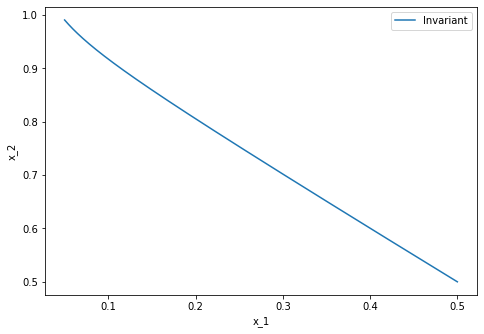

In [622]:
#plot curve invariant
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( x_1, x_2, label='Invariant')
ax.legend()
ax.set_xlabel("x_1")
ax.set_ylabel("x_2")

In [623]:
# price x_1(x_2)
p = get_price(K, x_1, x_2)

#LP price in x_1
lp_price = x_1/p + x_2

#LP price from virtual price
virtual_price = x_1+x_2

lp_virt = np.minimum( virtual_price / p, virtual_price)

Text(0, 0.5, 'Value')

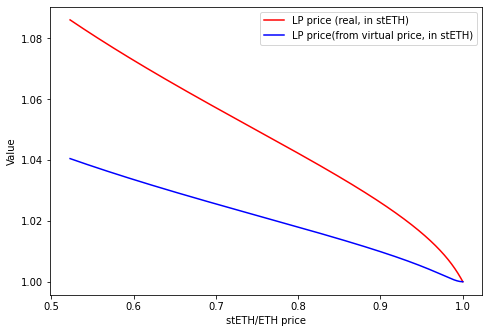

In [624]:


fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( p, lp_price, color='r', label='LP price (real, in stETH)')
ax.plot( p, lp_virt, color='b', label='LP price(from virtual price, in stETH)')
ax.legend()
ax.set_xlabel("stETH/ETH price")
ax.set_ylabel("Value")

In [752]:
lp_virt[np.searchsorted(p, 0.95, side="left")]

1.0050734127853311

Text(0, 0.5, 'Value')

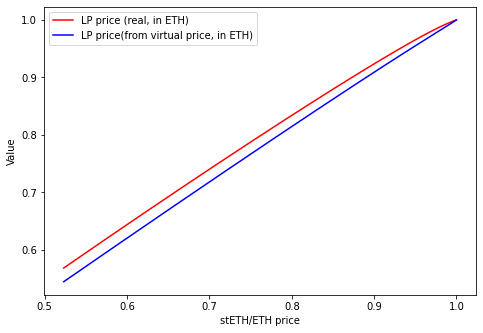

In [665]:

fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( p, lp_price*p, color='r', label='LP price (real, in ETH)')
ax.plot( p, lp_virt*p, color='b', label='LP price(from virtual price, in ETH)')
ax.legend()
ax.set_xlabel("stETH/ETH price")
ax.set_ylabel("Value")

In [745]:
# slippage calculator

share = 0.03

position_x = x_1 * share
position_y = 0.06 + 0 * x_2 # 
#position_y = x_2 * share

value_before = position_x/p + position_y #value in stETH
x_12 = y_x(A,D, x_2+position_y)

value_after = (x_1 - x_12)/p + position_x/p 
slippage = (value_after - value_before)/value_before

Text(0, 0.5, 'position, stETH')

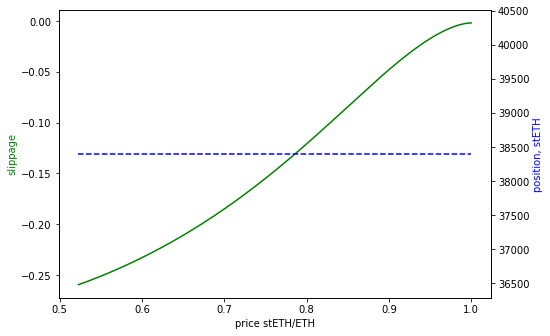

In [746]:
fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( p, slippage, color='g', label='Slippage')

ax2 = ax.twinx()
ax2.plot(p, 640000*position_y, 'b--')


ax.set_xlabel("price stETH/ETH")
ax.set_ylabel("slippage", color='g')
ax2.set_ylabel('position, stETH', color='b')
#ax.legend()

Text(0, 0.5, 'Value')

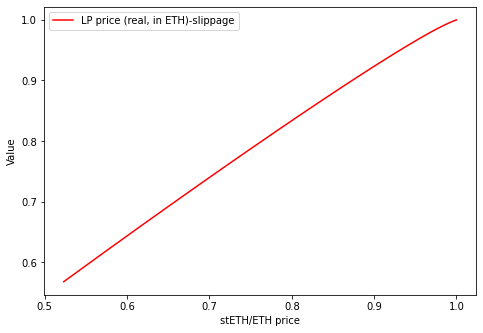

In [747]:

fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( p, lp_price*p, color='r', label='LP price (real, in ETH)-slippage')
ax.legend()
ax.set_xlabel("stETH/ETH price")
ax.set_ylabel("Value")

In [748]:
slippage[np.searchsorted(p, 0.9, side="left")]

-0.048037893159621974

Text(0, 0.5, 'Value')

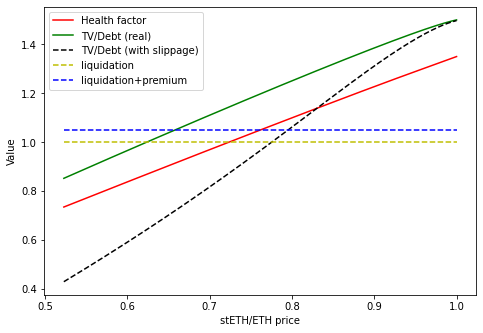

In [751]:

LT = 0.9 
Leverage = 3
fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])

health = lp_virt*p*LT*Leverage/(Leverage-1)
totalvalue_real = lp_price*(p)*Leverage/(Leverage-1) ## calculate what happens if large liquidation first and then ours
totalvalue_slippage = lp_price*(p+slippage)*Leverage/(Leverage-1) ## calculate what happens if large liquidation first and then ours

ax.plot( p, health, color='r', label='Health factor')
ax.plot( p, totalvalue_real, color='g', label='TV/Debt (real)')
ax.plot( p, totalvalue_slippage, 'k--', label='TV/Debt (with slippage)')
ax.plot( p, p * 0 + 1, 'y--', label='liquidation')
ax.plot( p, p * 0 + 1.05, 'b--', label='liquidation+premium')
ax.legend()
ax.set_xlabel("stETH/ETH price")
ax.set_ylabel("Value")

In [742]:
p+slippage

array([0.39409668, 0.39941637, 0.40469777, 0.4099406 , 0.41514458,
       0.42030947, 0.42543506, 0.43052116, 0.43556759, 0.44057422,
       0.44554092, 0.45046757, 0.4553541 , 0.46020044, 0.46500654,
       0.46977237, 0.47449792, 0.47918318, 0.48382818, 0.48843295,
       0.49299753, 0.49752199, 0.50200639, 0.50645084, 0.51085541,
       0.51522023, 0.51954541, 0.52383108, 0.52807738, 0.53228448,
       0.53645251, 0.54058166, 0.54467209, 0.548724  , 0.55273757,
       0.55671301, 0.56065051, 0.56455028, 0.56841256, 0.57223755,
       0.57602549, 0.5797766 , 0.58349114, 0.58716933, 0.59081143,
       0.59441768, 0.59798834, 0.60152366, 0.60502392, 0.60848935,
       0.61192024, 0.61531685, 0.61867945, 0.62200832, 0.62530371,
       0.62856592, 0.63179521, 0.63499186, 0.63815615, 0.64128837,
       0.64438879, 0.64745769, 0.65049535, 0.65350205, 0.65647808,
       0.65942371, 0.66233924, 0.66522493, 0.66808107, 0.67090795,
       0.67370583, 0.676475  , 0.67921574, 0.68192833, 0.68461